In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np

#导入数据集
breast = load_breast_cancer()
X = breast.data
y = breast.target
X_train,X_test,y_train,y_test =\
    train_test_split(X,y,test_size=0.2,random_state=1)

#流水线集成操作
pipe_lr = Pipeline([('scl',StandardScaler()),
                   ('pca',PCA(n_components=2)),
                   ('clf',LogisticRegression(solver='lbfgs',multi_class='auto'))])
pipe_lr.fit(X_train,y_train)
print ('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


# k折交叉验证
主要应用于评估一个模型的均值分及其上下限

In [2]:
#k折交叉验证
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10,random_state=1)
scores=[]
for k, (train,test) in enumerate(kfold.split(X_train, y_train)):
    pipe_lr.fit(X_train[train],y_train[train])
    score = pipe_lr.score(X_train[test],y_train[test])
    scores.append(score)
print ('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

CV accuracy: 0.952 +/- 0.025


In [3]:
#K折交叉验证评分
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,y=y_train,cv=10,n_jobs=1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                     np.std(scores)))

CV accuracy: 0.952 +/- 0.025


# 学习曲线
主要应用于评估一个模型对数据量上升的性能提升曲线

In [4]:
import matplotlib.pylab as plt
from sklearn.model_selection import learning_curve
pipe_lr = Pipeline([('scl',StandardScaler()),
                   ('clf',LogisticRegression(solver='lbfgs',multi_class='auto',\
                                             penalty='l2',random_state=0))])
train_sizes,train_scores,test_scores = \
    learning_curve(estimator=pipe_lr,
                  X=X_train,
                  y=y_train,
                  train_sizes=np.linspace(0.1,1.0,10),#控制用于生成学习曲线的样本数量百分比
                  cv=10,
                  n_jobs=1)
def cvCurve(train_sizes,train_scores,test_scores):
    train_mean = np.mean(train_scores,axis=1)
    train_std = np.std(train_scores,axis=1)
    test_mean = np.mean(test_scores,axis=1)
    test_std = np.std(test_scores,axis=1)
    plt.plot(train_sizes,train_mean,
            color='blue',marker='o',
            markersize=5,#标记尺寸
            label='training accuracy')
    plt.fill_between(train_sizes,
                    train_mean + train_std,
                    train_mean - train_std,
                    alpha=0.15,color='blue')
    plt.plot(train_sizes,test_mean,
            color='green',marker='s',
            markersize=5,#折线点大小
            label='validation accuracy')
    plt.fill_between(train_sizes,
                    test_mean + test_std,
                    test_mean - test_std,
                    alpha=0.15,color='green')
    plt.grid()#配置网格线
    plt.xlabel('Number of training samples or Parameter')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.8,1.0])#设置Y轴的上下限
cvCurve(train_sizes,train_scores,test_scores)
plt.show()

<Figure size 640x480 with 1 Axes>

# 验证曲线
主要应用于判断一个模型是否过拟合或欠拟合

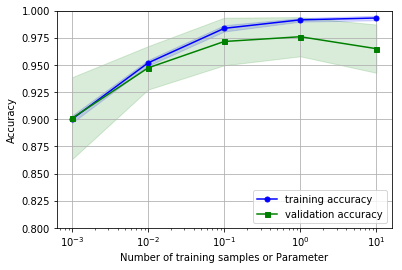

In [5]:
from sklearn.model_selection import validation_curve
param_range=[0.001,0.01,0.1,1.0,10.0]
train_scores,test_scores =validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name='clf__C',
    param_range=param_range,
    cv=10)
cvCurve(param_range,train_scores,test_scores)
plt.xscale('log')
plt.show()

# 网格搜索GridSearchCV

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = Pipeline([('scl',StandardScaler()),\
                    ('clf',SVC(random_state=1))])
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'clf__C': param_range,\
              'clf__kernel':['linear']},\
             {'clf__C':param_range,\
             'clf__gamma':param_range,\
             'clf__kernel':['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,\
                  param_grid=param_grid,\
                 scoring='accuracy',\
                 cv=10,n_jobs=-1,iid=False)
gs.fit(X_train,y_train)
print(gs.best_score_,gs.best_params_)
clf=gs.best_estimator_ #获取最佳分类器
clf.fit(X_train,y_train)
print('Test accuracy: %.3f' % clf.score(X_test,y_test))

0.9781159420289856 {'clf__C': 0.1, 'clf__kernel': 'linear'}
Test accuracy: 0.965


# 嵌套交叉验证

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

scores = cross_val_score(gs,X_train,y_train,scoring='accuracy',cv=5)
print ('CV accuracy: %.3f +/- %.3f' % \
      (np.mean(scores),np.std(scores)))

gst = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),\
                  param_grid=[{'max_depth':[1,2,3,4,5,6,7,None]}],\
                  scoring='accuracy',cv=5,iid=False)
scorest = cross_val_score(gst,X_train,y_train,scoring='accuracy',cv=5)
print ('CV accuracy: %.3f +/- %.3f' % \
       (np.mean(scorest),np.std(scorest)))

CV accuracy: 0.971 +/- 0.018
CV accuracy: 0.905 +/- 0.046


# 混淆矩阵
主要用于评估不平衡数据的模型性能

性能评估-metrics

绘制子图-subplots() 

绘制矩阵图-matshow() 

绘制文本框-text() 

混淆矩阵

[真负TN，假正FP]

[假负FN，真正TP]

[[40  2]
 [ 1 71]]


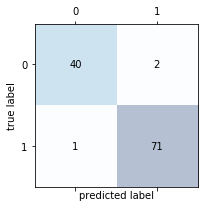

In [8]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test,y_pred=y_pred)
print(confmat)

fig,ax = plt.subplots(figsize = (3,3))
ax.matshow(confmat,cmap='Blues',alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,
               s=confmat[i,j],
               va='center',ha ='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

# 精确率和召回率

主要针对类别数量不均衡的分类问题

预测误差 ERR = (FP+FN)/(FP+FN+TP+TN)

准确率 ACC = (TP+TN)/(FP+FN+TP+TN)=1-ERR

精确率 PRE = TP/(TP+FP)

召回率 REC = TPR = TP/P = TP/(FN+TP)

In [37]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score,f1_score
print ('Precision : %.3f' % precision_score(\
                                           y_test,y_pred))
print ('Recall: %.3f' % f1_score(\
                                y_test,y_pred))
print('F1: %.3f' % f1_score(\
                           y_test,y_pred))

#构建自己的评分器
from sklearn.metrics import make_scorer,f1_score
scorer = make_scorer(f1_score,
                     pos_label=1,#正例类标
                     greater_is_better=True,#评价方向
                     averge='micro')#支持多分类评价

Precision : 0.973
Recall: 0.979
F1: 0.979


# ROC曲线
受试者工作特征曲线

roc的对角线可以理解为随机猜测，如果分类器性能曲线在对角线以下，那么其性能就比随机猜测还差，对于完美的分类器来说，其真正率为1，假正率为0，这时的roc曲线即为横轴0与纵轴1组成的折线

roc_curve返回参数：

fpr 假正率，使元素i为得分大于等于阈值的预测假阳性率[i]。

tpr 真正率，使元素i为预测的真阳性率，得分大于等于阈值[i]。

thresholds 用于计算fpr和tpr的决策函数的降低阈值。阈值[0]表示没有正在预测的实例，可任意设置为max（y_score）+1。

线性插值概念：数学上定义:线性插值是指插值函数为一次多项式的插值方式,其在插值节点上的插值误差为0;在图片上，我们利用线性插值的算法，可以减少图片的锯齿,模糊图片; 举例：y= x +1  x[0,1,3] y[1,2,4] 利用X 1和3中值2 形成x[0,1,2,3] 往Y轴上插值得到y[1,2,3,4] 

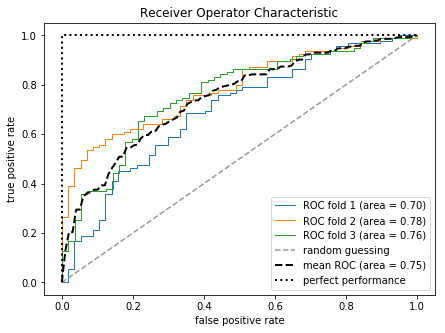

In [35]:
from sklearn.metrics import roc_curve,auc
from numpy import interp
X_train2 = X_train[:,[4,14]]
fig=plt.figure(figsize=(7,5))
mean_tpr=0.0
mean_fpr = np.linspace(0,1,100)
all_tpr=[]
cv = StratifiedKFold(n_splits=3)

#绘制模型k折性能曲线
for i,(train,test) in enumerate(cv.split(X_train2, y_train)):
    #获取模型对测试集各类标的预测概率
    lrbas=pipe_lr.fit(X_train2[train],y_train[train])
    probas=lrbas.predict_proba(X_train2[test])
    fpr,tpr,thresholds = roc_curve(y_train[test],
                                  probas[:,1],#获取类标1的预测概率
                                  pos_label=1)#指定类标1设为正例的标签
    mean_tpr += interp(mean_fpr,fpr,tpr)#获取一维线性插值
    mean_tpr[0]=0.0
    roc_auc=auc(fpr,tpr)#使用梯形规则计算曲线下面积（AUC）
    plt.plot(fpr,tpr,lw=1,label='ROC fold %d (area = %0.2f)' % (i+1,roc_auc))

#绘制随机猜测性能曲线
plt.plot([0,1],
        [0,1],
        linestyle='--',
        color=(0.6,0.6,0.6),
        label='random guessing')

#绘制模型平均性能曲线
mean_tpr /= len (list(cv.split(X_train2, y_train)))
mean_tpr [-1]=1.0
mean_auc=auc(mean_fpr,mean_tpr)
plt.plot(mean_fpr,mean_tpr,'k--',
        label='mean ROC (area = %0.2f)' % mean_auc, linewidth=2)

#绘制完美性能曲线
plt.plot([0,0,1],
        [0,1,1],
        linewidth=2,
        linestyle=':',
        color='black',
        label='perfect performance')

plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc='lower right')#图例置于右下角
plt.show()

# ROC AUC得分

In [31]:
pipe_svc = pipe_svc.fit(X_train2,y_train)
y_pred2 = pipe_svc.predict(X_test[:,[4,14]])
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
print('ROC AUC: %.3f' % roc_auc_score(y_test,y_pred2))
print('Accyracy: %.3f' % accuracy_score(y_test,y_pred2))

ROC AUC: 0.671
Accyracy: 0.728
